In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Research Question: ##
How can new Airbnb hosts in Dallas, Texas set a competitive and profit-producing base price for their properties based on significant features such as bedrooms, type of room, level of accommodation, availability, etc?

## Import and Clean Data ##

In [2]:
# Read in data
df = pd.read_csv('listings.csv')
df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,61878,https://www.airbnb.com/rooms/61878,20240521161608,2024-05-22,city scrape,MODERN LIVING AND FURNISHINGS,Close to downtown and Uptown. Fast and conven...,Enjoy the heart of Dallas right out your door ...,https://a0.muscache.com/pictures/c4d9625e-bcc5...,300211,...,4.92,4.75,4.77,NaN,f,1,1,0,0,0.34
1,270936,https://www.airbnb.com/rooms/270936,20240521161608,2024-05-22,city scrape,1BR 1BA Oaklawn Condo Close to Downtown & Uptown,Please submit purpose of visit with request. ...,"The address is 4340 Cedar Springs Road Dallas,...",https://a0.muscache.com/pictures/c5991432-c923...,1417982,...,4.95,4.91,4.93,NaN,f,1,1,0,0,0.41
2,795703,https://www.airbnb.com/rooms/795703,20240521161608,2024-05-22,city scrape,Amazing location walk to Downtown Dallas,***** Over 30% Discounts for stays over 30 day...,Located in Turtle Creek neighborhood steps fro...,https://a0.muscache.com/pictures/miso/Hosting-...,4191322,...,4.97,4.91,4.75,NaN,f,1,1,0,0,0.51


In [3]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
columns_to_keep = [
    'id', 'availability_30', 'availability_60', 'availability_90', 'availability_365',
    'room_type', 'accommodates', 'bedrooms', 'price', 'minimum_nights'
]

df = df[columns_to_keep]

desired_order = ['accommodates', 'bedrooms', 'price', 'minimum_nights',
                   'availability_30', 'availability_60', 'availability_90',
                   'availability_365', 'room_type_Entire home/apt',
                   'room_type_Hotel room', 'room_type_Private room',
                   'room_type_Shared room']

df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')


# Remove dollar signs and commas from 'price' column
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

# Fill in NaN values
df['price'] = df['price'].fillna(0)


# Convert 'price' column to integers
df['price'] = df['price'].astype(int)

df.set_index('id', inplace=True)


df = df[desired_order]

df.head()

,accommodates,bedrooms,price,minimum_nights,availability_30,availability_60,availability_90,availability_365,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,
61878,3,1.0,95,30,17,17,20,295,1,0,0,0
270936,2,1.0,74,30,14,26,55,55,1,0,0,0
795703,2,1.0,243,30,0,0,23,200,1,0,0,0
826118,2,1.0,62,14,0,0,11,101,0,0,1,0
826201,2,1.0,54,30,2,2,2,83,0,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5054 entries, 61878 to 1160946230504794412
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               5054 non-null   int64  
 1   bedrooms                   5009 non-null   float64
 2   price                      5054 non-null   int32  
 3   minimum_nights             5054 non-null   int64  
 4   availability_30            5054 non-null   int64  
 5   availability_60            5054 non-null   int64  
 6   availability_90            5054 non-null   int64  
 7   availability_365           5054 non-null   int64  
 8   room_type_Entire home/apt  5054 non-null   uint8  
 9   room_type_Hotel room       5054 non-null   uint8  
 10  room_type_Private room     5054 non-null   uint8  
 11  room_type_Shared room      5054 non-null   uint8  
dtypes: float64(1), int32(1), int64(6), uint8(4)
memory usage: 355.4 KB


In [6]:
# Filling in NaN values with 1
df['bedrooms'] = df['bedrooms'].fillna(1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5054 entries, 61878 to 1160946230504794412
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accommodates               5054 non-null   int64  
 1   bedrooms                   5054 non-null   float64
 2   price                      5054 non-null   int32  
 3   minimum_nights             5054 non-null   int64  
 4   availability_30            5054 non-null   int64  
 5   availability_60            5054 non-null   int64  
 6   availability_90            5054 non-null   int64  
 7   availability_365           5054 non-null   int64  
 8   room_type_Entire home/apt  5054 non-null   uint8  
 9   room_type_Hotel room       5054 non-null   uint8  
 10  room_type_Private room     5054 non-null   uint8  
 11  room_type_Shared room      5054 non-null   uint8  
dtypes: float64(1), int32(1), int64(6), uint8(4)
memory usage: 355.4 KB


<Axes: title={'center': 'Price Distribution'}, xlabel='price'>

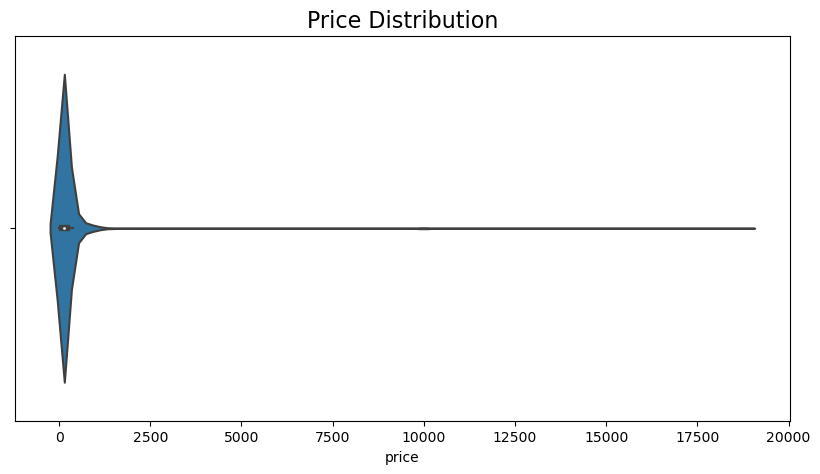

In [8]:
plt.figure(figsize=(10, 5))
plt.rc(['axes'], labelsize=16, titlesize=16)

# Plot the violin plot
plt.title("Price Distribution")
sns.violinplot(x=df['price'])

In [9]:
df['price'].describe()

count     5054.000000
mean       222.481401
std        677.969451
min          0.000000
25%         85.000000
50%        121.500000
75%        203.750000
max      18824.000000
Name: price, dtype: float64

75th quartile:  203.75
25th quartile:  85.0
IQR:  118.75
Upper limit:  381.875
Lower limit:  -93.125
Shape after removing upper outliers:  (4593, 12)


<Axes: title={'center': 'Price Distribution After Removing Upper Outliers'}, xlabel='price'>

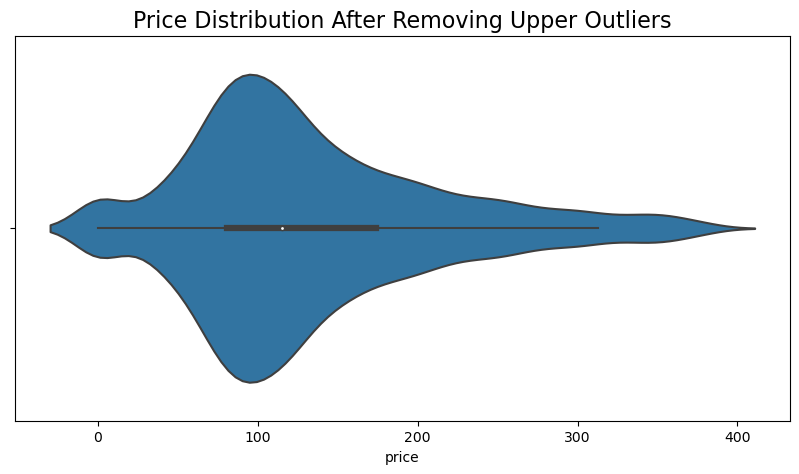

In [10]:
# Calculate the first and third quartiles
percentile25 = df['price'].quantile(0.25)
percentile75 = df['price'].quantile(0.75)
print("75th quartile: ", percentile75)
print("25th quartile: ", percentile25)

# Calculate the IQR
iqr = percentile75 - percentile25
print("IQR: ", iqr)

# Define the upper and lower limits using 1.5 times the IQR
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit: ", upper_limit)
print("Lower limit: ", lower_limit)

# Remove upper outliers
df = df[df['price'] < upper_limit]
print("Shape after removing upper outliers: ", df.shape)

# Visualize the price distribution using a boxplot
plt.figure(figsize=(10, 5))
plt.rc(['axes'], labelsize=16, titlesize=16)
plt.title("Price Distribution After Removing Upper Outliers")
sns.violinplot(x=df['price'])

In [11]:
df['price'].describe()

count    4593.000000
mean      133.576312
std        80.269599
min         0.000000
25%        81.000000
50%       115.000000
75%       174.000000
max       381.000000
Name: price, dtype: float64

## Exploratory Data Analysis ##

Text(0.5, 0.98, 'Histograms of Numerical Features')

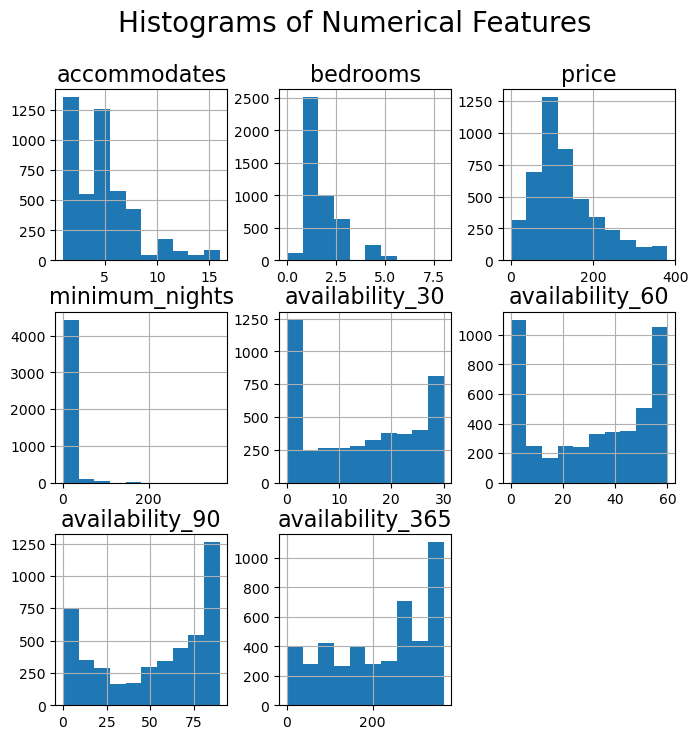

In [12]:
# Distribution of each originally numerical feature
df.hist(['accommodates', 'bedrooms', 'price', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365'], figsize=(8, 8))
plt.suptitle('Histograms of Numerical Features', size=20)

**Splitting Data**

In [13]:
# Identify independent and dependent variables
X = df.drop(['price'], axis=1)
y = df['price']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Print lengths of train and test sets
print(f"Train set - X: {len(X_train)}, y: {len(y_train)}")
print(f"Test set - X: {len(X_test)}, y: {len(y_test)}")

Train set - X: 3674, y: 3674
Test set - X: 919, y: 919


**Multiple Regression**

In [14]:
# Fit regression model
mlr = LinearRegression()
mlr.fit(X_train, y_train)

# Predict price on training data
y_train_pred = mlr.predict(X_train)
print('Results for multiple regression on training data')
print('MAE is ', mean_absolute_error(y_train, y_train_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('MSE is ', mean_squared_error(y_train, y_train_pred))
print('R^2 ', r2_score(y_train, y_train_pred))

# Predict price on test data
y_test_pred = mlr.predict(X_test)
print()
print('Results for multiple regression on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test, y_test_pred))

Results for multiple regression on training data
MAE is  42.79980478193572
RMSE is  59.648113853223826
MSE is  3557.897486247152
R^2  0.44636539805881537

Results for multiple regression on test data
MAE is  43.728133263478725
RMSE is  61.05716215709569
MSE is  3727.977050677878
R^2  0.4267281846257829


### Summary ###

Our model was used to predict house prices, and here's how well it performed. On average, our predictions were off by about `$43`. For most houses, the typical error was around `$61`, meaning our guesses were usually within `$61` of the actual price. Our model was able to explain about 43% of the reasons why house prices vary, which means it did a decent job but still has room for improvement. Overall, the model's predictions were fairly consistent between the data we used to train it and the data we used to test it.

**Decision Tree**

In [15]:
# Fit regression model on the entire dataset
dt = DecisionTreeRegressor()
dt.fit(X, y)

# Predict price on the entire dataset
y_pred = dt.predict(X)
print('Results for decision tree regression on the entire dataset')
print('MAE is ', mean_absolute_error(y, y_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is ', mean_squared_error(y, y_pred))
print('R^2 ', r2_score(y, y_pred))

# Predict price on the test data
y_test_pred = dt.predict(X_test)
print()
print('Results for decision tree regression on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test, y_test_pred))

Results for decision tree regression on the entire dataset
MAE is  3.231858765713993
RMSE is  14.807379538635805
MSE is  219.2584888012103
R^2  0.9659631942368846

Results for decision tree regression on test data
MAE is  3.129821696542237
RMSE is  13.682484047987185
MSE is  187.21036972342375
R^2  0.9712116177086685


### Summary ###

The decision tree regression model performed extremely well in predicting prices. It was able to explain about 96.6% of the variation in the prices using the entire dataset and 97.1% using the test data. The average error in predictions was around $3, indicating high accuracy. This model is reliable and effective for our dataset, capturing most of the price variation accurately.

In [16]:
# Calculate the importance of each feature
ft_weight_dt = pd.DataFrame(dt.feature_importances_, columns=['weight'], index=X.columns)

# Sort the features by their importance
ft_weight_dt.sort_values('weight', inplace=True)

# Display the sorted features with their importance weights
ft_weight_dt

,weight
room_type_Shared room,0.000002
room_type_Private room,0.008940
room_type_Hotel room,0.021967
room_type_Entire home/apt,0.033125
availability_60,0.049841
availability_30,0.067735
availability_90,0.071896
accommodates,0.073410
minimum_nights,0.080832
availability_365,0.194357


These results provide insights into which features the decision tree model considers most important for predicting the price of Airbnb listings. Features such as the number of bedrooms, availability over the year, minimum nights, and accommodation capacity have the greatest influence on the model's predictions. This information can help hosts understand what aspects of their listings might affect pricing the most, allowing them to optimize their pricing strategies accordingly. It found that the number of bedrooms and how often the property is available throughout the year are the most important factors. Features like the minimum nights required and the property's capacity also played a significant role. Surprisingly, the type of room (such as entire home, hotel room, private room, or shared room) had less impact on pricing.

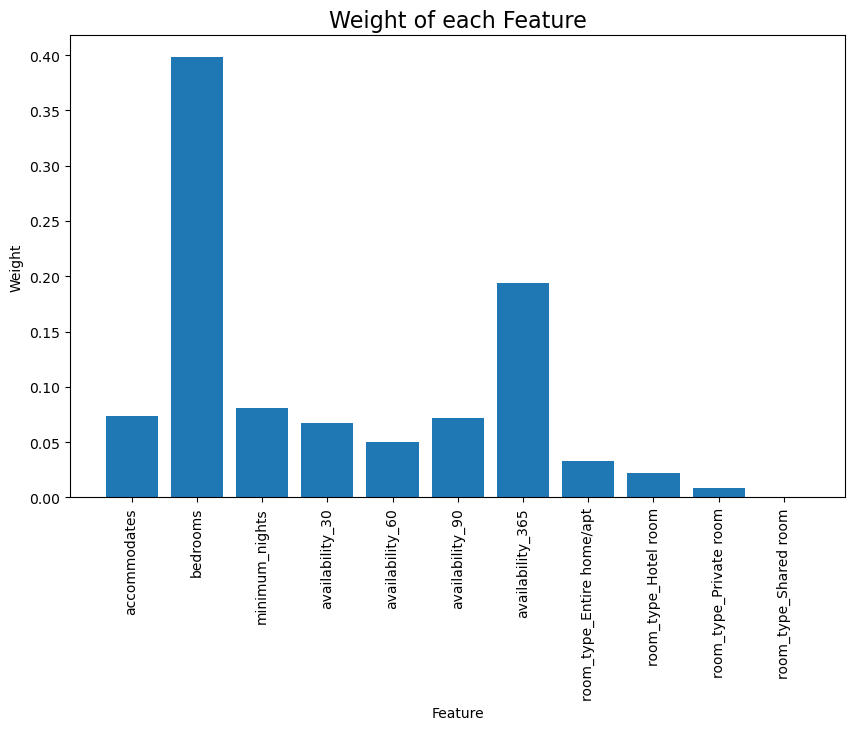

In [17]:
plt.figure(figsize=(10,6))
plt.bar([x for x in range(len(dt.feature_importances_))], dt.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Weight of each Feature')
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.show()

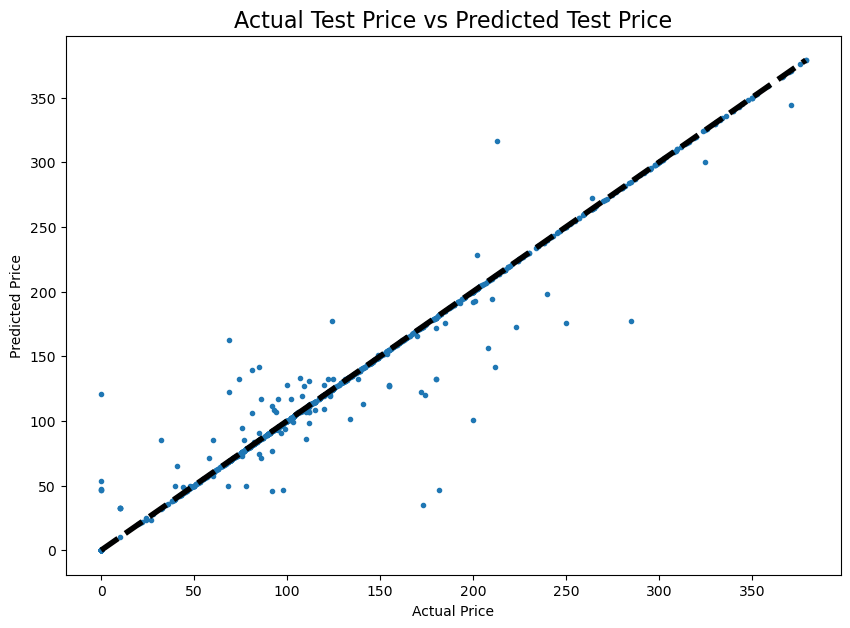

In [18]:
plt.figure(figsize=(10,7))
scatter = plt.scatter(y_test, y_test_pred, marker=".")
plt.title("Actual Test Price vs Predicted Test Price")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

**Random Forest**

In [19]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

rf.fit(X, y)

# Predict prices on the entire dataset
y_pred = rf.predict(X)

# Evaluate the model on the entire dataset
print('Results for random forest on the entire dataset')
print('MAE is ', mean_absolute_error(y, y_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is ', mean_squared_error(y, y_pred))
print('R^2 ', r2_score(y, y_pred))

# Predict prices on the test data
y_test_pred = rf.predict(X_test)

# Evaluate the model on the test data
print('\nResults for random forest on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test, y_test_pred))

Results for random forest on the entire dataset
MAE is  15.86000371096704
RMSE is  24.535479376718484
MSE is  601.9897482453781
R^2  0.9065495331813963

Results for random forest on test data
MAE is  15.711794415283206
RMSE is  24.18650847390745
MSE is  584.9871921583967
R^2  0.9100432580296248


### Summary ###

The Random Forest model predicts Airbnb prices with an average error of about `$15.86` when tested on the entire dataset and `$15.71` on the test data. The model explains 91% of the variation in prices, indicating a high level of accuracy. The errors are a little larger than those from the Decision Tree model but still had a strong performance.

**Extreme Gradient Boost**

In [20]:
# Fit regression model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X, y)

# Predict price on training data
y_train_pred = xgb_reg.predict(X)
print('Results for xgboost on training data')
print('MAE is ', mean_absolute_error(y, y_train_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y, y_train_pred)))
print('MSE is ', mean_squared_error(y, y_train_pred))
print('R^2 ', r2_score(y, y_train_pred))

# Predict price on test data
y_test_pred = xgb_reg.predict(X_test)
print()
print('Results for xgboost on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test, y_test_pred))

Results for xgboost on training data
MAE is  20.611009638170103
RMSE is  30.4380296298266
MSE is  926.4736477462021
R^2  0.8561779579646157

Results for xgboost on test data
MAE is  20.434209479471026
RMSE is  30.071601044131913
MSE is  904.3011893574356
R^2  0.860940564434608


# Model Results #

| Model              | Training Features | Set      | MAE   | RMSE  | R² (%) |
|--------------------|-------------------|----------|-------|-------|--------|
| Multiple Regression| Independent       | Training | 42.80 | 59.65 | 44.64  |
| Multiple Regression| Independent       | Test     | 43.73 | 61.06 | 42.67  |
| Decision Tree      | Independent       | Training | 3.23  | 14.81 | 96.60  |
| Decision Tree      | Independent       | Test     | 3.13  | 13.68 | 97.12  |
| Random Forest      | Independent       | Training | 15.86 | 24.54 | 90.65  |
| Random Forest      | Independent       | Test     | 15.71 | 24.19 | 91.00  |
| XGBoost            | Independent       | Training | 20.61 | 30.44 | 85.62  |
| XGBoost            | Independent       | Test     | 20.43 | 30.07 | 86.09  |


The Decision Tree Regression model appeared as the most accurate and reliable model for predicting Airbnb prices in this dataset. Future work could involve exploring more complex models, fine-tuning the hyperparameters, or incorporating additional features to further improve prediction accuracy.